## Navier-Stokes Modeling

### Setup

Import all necessary libraries as well as functions and classes from the helper files

In [144]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from model import DiffusionModel, DiffusionTransformer, timestep_embedding, save_checkpoint, load_checkpoint
from lattice_boltzmann import BoltzmannSimulation, LatticeBoltzmannDataset
from navier_stokes import NavierStokesSimulator, NavierStokesDataset, forcing_same_as_paper

Define relevant parameters

In [145]:
# Dimensions of the simulation
NX = 32
NY = 32
nu = 1e-5
delta_t = 0.05
simulation_length = 50
number_of_simulations = 300

# Hyperparams for training
batch_size = 8
num_epochs = 300
timesteps = 200
learning_rate = 1e-4

Functions

In [146]:
def plot_losses(epochs, train_losses, val_losses, title="Loss", save_path=None):
    plt.style.use('seaborn-v0_8-paper')
    plt.figure(figsize=(6, 4))

    plt.plot(epochs, train_losses, label='Training Loss', color='blue', linewidth=1.5, alpha=0.8)
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', linewidth=1.5, alpha=0.8)

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10, loc='upper right')
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

### Generate Data

Run the simulation defined in the `navier_stokes.py` file and save each simulation as a separate file in the `navier_stokes` folder.

In [147]:
# Make directory for the simulation data results
os.makedirs("navier_stokes", exist_ok=True)

pbar = tqdm(range(number_of_simulations))
for i in pbar:
    sim = NavierStokesSimulator(nx=NX, ny=NY, dt=delta_t, nt=simulation_length, nu=nu, forcing=forcing_same_as_paper)

    sim.set_random_initial_condition()
    w_data, _, _ = sim.run()
    
    # Save data
    np.save(f"navier_stokes/vorticity_data_{i}.npy", w_data)

100%|██████████| 300/300 [00:06<00:00, 45.64it/s]


Visualize the result of the last simulation

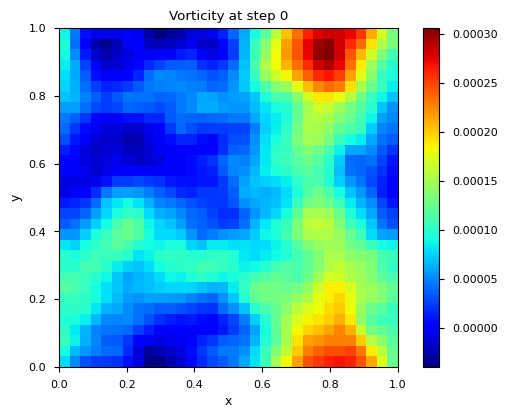

In [148]:
sim.visualize_simulation(w_data, interval=50)
# If you want to see the .gif file of the simulation in action, uncomment this code:
#sim.visualize_simulation(w_data, save="vorticity_evolution.gif")

### Load data

Load the previous simulations into a `DataLoader`

In [149]:
base_path = "navier_stokes/"
split = [0.7, 0.2]

In [150]:
dataset = NavierStokesDataset([base_path + f"vorticity_data_{i}.npy" for i in range(int(number_of_simulations*split[0]))])

training_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract mean and std from dataset for denormalization later
training_data_mean = dataset.mean
training_data_std = dataset.std

In [151]:
dataset = NavierStokesDataset([base_path + f"vorticity_data_{i}.npy" for i in range(int(number_of_simulations*split[0]), int(number_of_simulations*split[0]) + int(number_of_simulations*split[1]))])

test_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract mean and std from dataset for denormalization later
test_data_mean = dataset.mean
test_data_std = dataset.std

In [152]:
dataset = NavierStokesDataset([base_path + f"vorticity_data_{i}.npy" for i in range(int(number_of_simulations*split[0]) + int(number_of_simulations*split[1]), number_of_simulations)])

validation_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract mean and std from dataset for denormalization later
validation_data_mean = dataset.mean
validation_data_std = dataset.std

### Model setup

In [153]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model = DiffusionTransformer(
    in_channels=11,
    out_channels=1,
    img_size=(NX,NY),
    patch_size=8,
    embed_dim=256,
    depth=4,
    num_heads=8
).to(device)

diffusion = DiffusionModel(model, timesteps=timesteps, lr=learning_rate, device=device)

# While the model has an optimizer and scheduler defined, doing it separately seems to work better for some reason
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(training_data),
    epochs=num_epochs,
)

### Model training

In [28]:
best_val_loss = float('inf')
pbar = tqdm(range(num_epochs))
epochs_without_improvement = 0
patience = 20

train_loss_history = []
val_loss_history = []

for epoch in pbar:
    train_loss = 0.0
    for x, y in training_data:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        loss = diffusion.p_losses(x, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss = train_loss / len(training_data)
    train_loss_history.append(train_loss)

    val_loss = 0.0
    for x_val, y_val in validation_data:
        x_val, y_val = x_val.to(device), y_val.to(device)

        loss = diffusion.p_losses(x, y)

        val_loss += loss.item()
    
    val_loss = val_loss / len(validation_data)
    val_loss_history.append(val_loss)
        
    pbar.set_postfix_str(f"Training Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement > patience:
        break

 42%|████▏     | 126/300 [1:04:45<1:29:26, 30.84s/it, Training Loss: 0.01259217, Validation Loss: 0.01440452]


Manual saving and loading in case its needed (commented out)

In [ ]:
#save_checkpoint(model, optimizer, epoch, train_loss_history[-1], filepath=f"models/navier_stokes.pth")
#epoch, loss = load_checkpoint("models/navier_stokes.pth", model, optimizer)

### Visualize loss

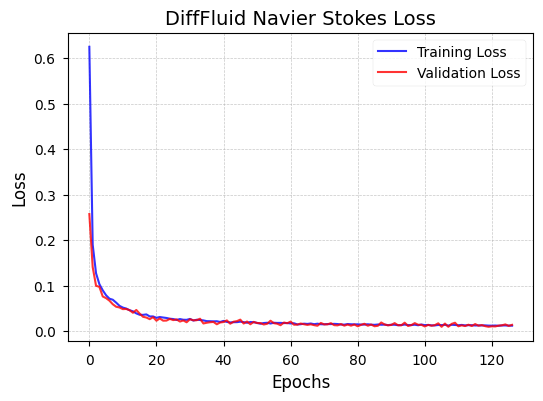

In [31]:
plot_losses([*range(len(train_loss_history))], train_loss_history, val_loss_history, title="DiffFluid Navier Stokes Loss")

### Calculate error

In [155]:
numerator = 0
denominator = 0

total_pixels = 0

with torch.no_grad():
    for x, y in test_data:
        x, y = x.to(device), y.to(device)
        y_pred = diffusion.sample(x)

        y_true = y.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        numerator += np.sum((y_pred - y_true) ** 2)
        denominator += np.sum(y_true ** 2)

        total_pixels += y_true.size

mse_error_bp = numerator / total_pixels
print(f"MSE error (by pixel): {mse_error_bp}")

mse_error_bs = numerator / len(test_data)
print(f"MSE error (by sample): {mse_error_bs}")

l2_error = np.sqrt(numerator) / np.sqrt(denominator)
print(f"L2 relative error: {l2_error}")


MSE error (by pixel): 0.006353941709579279
MSE error (by sample): 52.051490484873455
L2 relative error: 0.07967291237270148


### Visualize result

Takes the next pair from the test data and plots it vs. the ground truth (plus an error map)

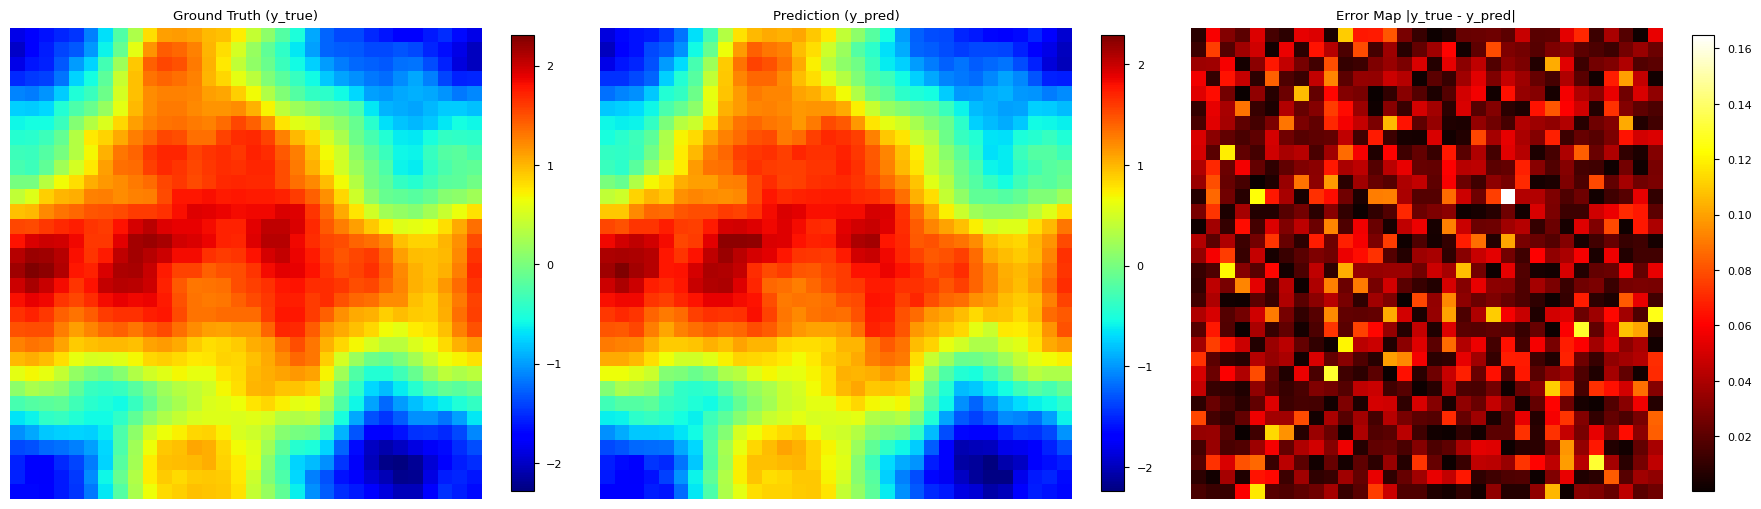

In [36]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for x, y in validation_data: 
        x, y = x.to(device), y.to(device)

        t = torch.randint(0, timesteps, (x.shape[0],), device=device).long()
        t_emb = timestep_embedding(t, model.patch_embed.proj.out_channels).to(device)

        y_pred = diffusion.sample(x)

        y_true = y[0].squeeze().cpu().numpy()
        y_pred = y_pred[0].squeeze().cpu().numpy()

        x_prev = x[0, -1].squeeze().cpu().numpy()

        error_map = np.abs(y_true - y_pred)

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        idx_true = 0
        im1 = ax[idx_true].imshow(y_true, cmap='jet', origin='lower')
        ax[idx_true].set_title("Ground Truth (y_true)")
        ax[idx_true].axis('off')
        fig.colorbar(im1, ax=ax[idx_true], shrink=0.8)

        idx_pred = 1
        im2 = ax[idx_pred].imshow(y_pred, cmap='jet', origin='lower')
        ax[idx_pred].set_title("Prediction (y_pred)")
        ax[idx_pred].axis('off')
        fig.colorbar(im2, ax=ax[idx_pred], shrink=0.8)

        idx_error = 2
        im3 = ax[idx_error].imshow(error_map, cmap='hot', origin='lower')
        ax[idx_error].set_title("Error Map |y_true - y_pred|")
        ax[idx_error].axis('off')
        fig.colorbar(im3, ax=ax[idx_error], shrink=0.8)

        plt.tight_layout()
        plt.show()
        break

## Lattice Boltzmann

### Generate Data

Run the simulation defined in the `lattice_boltzmann.py` file and save each simulation as a separate file in the `lattice_boltzmann` folder.

In [156]:
# Make directory for the simulation data results
os.makedirs("lattice_boltzmann", exist_ok=True)

pbar = tqdm(range(number_of_simulations))
for i in pbar:
    sim = BoltzmannSimulation(nx=NX, ny=NY, timesteps=simulation_length, U=0.1)

    sim.run()
    
    # Save data
    sim.save_data(f"lattice_boltzmann/rho_data_{i}.npz")

100%|██████████| 300/300 [00:13<00:00, 22.78it/s]


Visualize the result of the last simulation

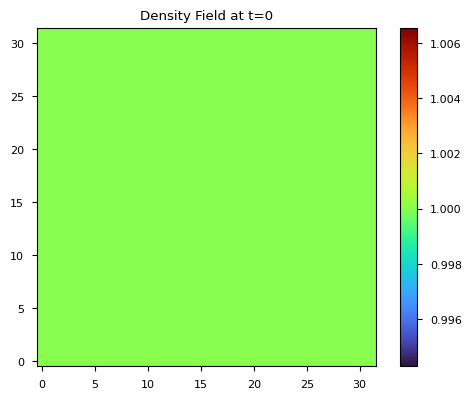

In [126]:
sim.visualize()
# If you want to see the .gif file of the simulation in action, uncomment this code:
#sim.visualize_simulation(w_data, save="vorticity_evolution.gif")

### Load data

Load the previous simulations into a `DataLoader`

In [157]:
base_path = "lattice_boltzmann/"
split = [0.7, 0.2]

In [158]:
dataset = LatticeBoltzmannDataset([base_path + f"rho_data_{i}.npz" for i in range(int(number_of_simulations*split[0]))])

training_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract mean and std from dataset for denormalization later
training_data_mean = dataset.mean
training_data_std = dataset.std

In [159]:
dataset = LatticeBoltzmannDataset([base_path + f"rho_data_{i}.npz" for i in range(int(number_of_simulations*split[0]), int(number_of_simulations*split[0]) + int(number_of_simulations*split[1]))])

test_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract mean and std from dataset for denormalization later
test_data_mean = dataset.mean
test_data_std = dataset.std

In [160]:
dataset = LatticeBoltzmannDataset([base_path + f"rho_data_{i}.npz" for i in range(int(number_of_simulations*split[0]) + int(number_of_simulations*split[1]), number_of_simulations)])

validation_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract mean and std from dataset for denormalization later
validation_data_mean = dataset.mean
validation_data_std = dataset.std

### Model setup

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model2 = DiffusionTransformer(
    in_channels=11,
    out_channels=1,
    img_size=(NX,NY),
    patch_size=8,
    embed_dim=256,
    depth=4,
    num_heads=8
).to(device)

diffusion2 = DiffusionModel(model2, timesteps=timesteps, lr=learning_rate, device=device)

# While the model has an optimizer and scheduler defined, doing it separately seems to work better for some reason
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(training_data),
    epochs=num_epochs,
)

### Model training

In [9]:
best_val_loss = float('inf')
pbar = tqdm(range(num_epochs))
epochs_without_improvement = 0
patience = 20

train_loss_history = []
val_loss_history = []

for epoch in pbar:
    train_loss = 0.0
    for x, y in training_data:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        loss = diffusion2.p_losses(x, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss = train_loss / len(training_data)
    train_loss_history.append(train_loss)

    val_loss = 0.0
    for x_val, y_val in validation_data:
        x_val, y_val = x_val.to(device), y_val.to(device)

        loss = diffusion2.p_losses(x, y)

        val_loss += loss.item()
    
    val_loss = val_loss / len(validation_data)
    val_loss_history.append(val_loss)
        
    pbar.set_postfix_str(f"Training Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement > patience:
        break

 33%|███▎      | 99/300 [48:59<1:39:28, 29.69s/it, Training Loss: 0.01964154, Validation Loss: 0.01824804]


In [ ]:
#save_checkpoint(model, optimizer, epoch, epoch_loss / len(data_loader), filepath=f"models/navier_stokes_epoch_{epoch}.pth")
#epoch, loss = load_checkpoint("models/lattice_boltzmann.pth", model2, optimizer)

### Visualize loss

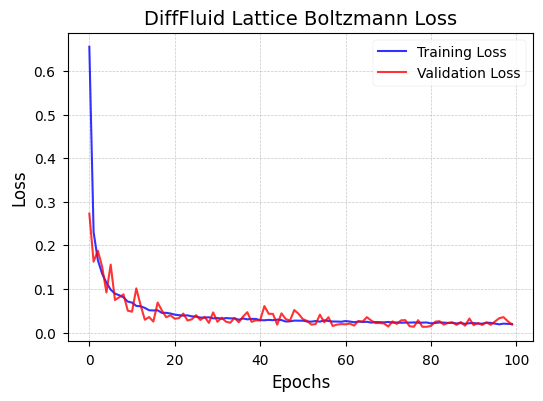

In [11]:
plot_losses([*range(len(train_loss_history))], train_loss_history, val_loss_history, title="DiffFluid Lattice Boltzmann Loss")

### Calculate error

In [163]:
numerator = 0
denominator = 0

total_pixels = 0

with torch.no_grad():
    for x, y in test_data:
        x, y = x.to(device), y.to(device)
        y_pred = diffusion2.sample(x)

        y_true = y.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        numerator += np.sum((y_pred - y_true) ** 2)
        denominator += np.sum(y_true ** 2)

        total_pixels += y_true.size

mse_error_bp = numerator / total_pixels
print(f"MSE error (by pixel): {mse_error_bp}")

mse_error_bs = numerator / len(test_data)
print(f"MSE error (by sample): {mse_error_bs}")

l2_error = np.sqrt(numerator) / np.sqrt(denominator)
print(f"L2 relative error: {l2_error}")


MSE error (by pixel): 0.00142178463552577
MSE error (by sample): 11.627383864373478
L2 relative error: 0.059799296889498


### Visualize result

Takes the next pair from the test data and plots it vs. the ground truth (plus an error map).

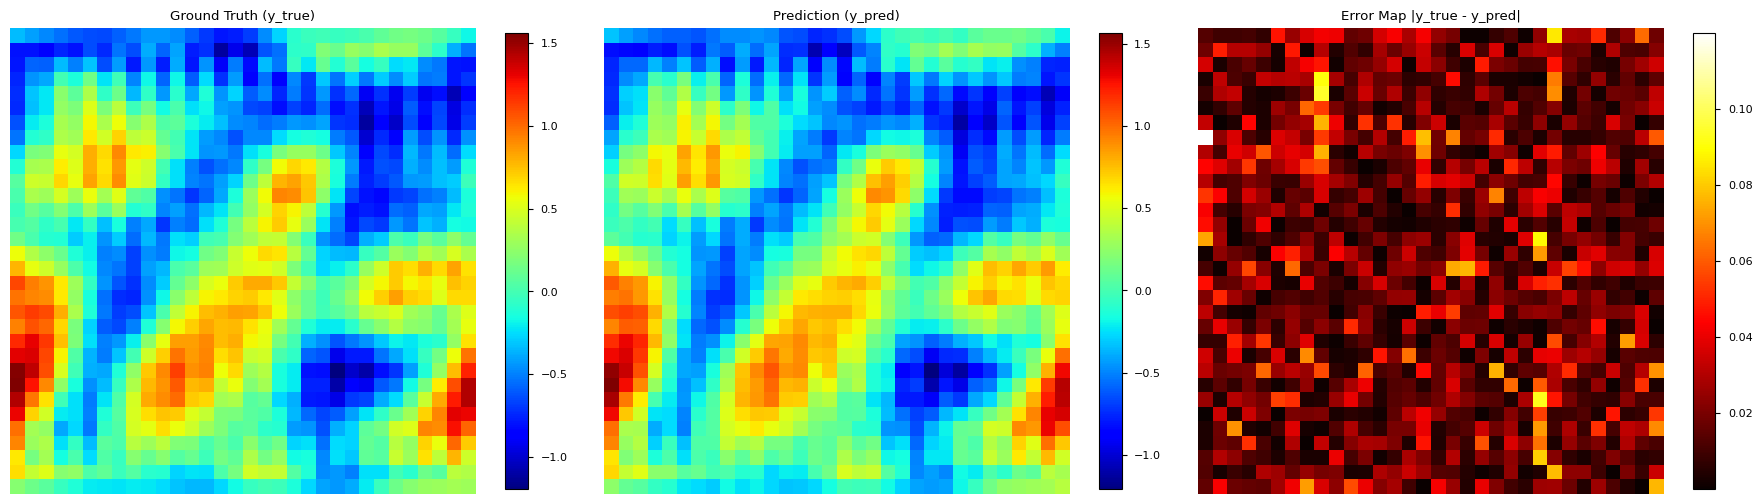

In [92]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for x, y in validation_data:
        x, y = x.to(device), y.to(device)
        
        t = torch.randint(0, timesteps, (x.shape[0],), device=device).long()
        t_emb = timestep_embedding(t, model2.patch_embed.proj.out_channels).to(device)

        y_pred = diffusion2.sample(x)

        y_true = y[0].squeeze().cpu().numpy()
        y_pred = y_pred[0].squeeze().cpu().numpy()

        x_prev = x[0, -1].squeeze().cpu().numpy()

        error_map = np.abs(y_true - y_pred)

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        idx_true = 0
        im1 = ax[idx_true].imshow(y_true, cmap='jet', origin='lower')
        ax[idx_true].set_title("Ground Truth (y_true)")
        ax[idx_true].axis('off')
        fig.colorbar(im1, ax=ax[idx_true], shrink=0.8)

        idx_pred = 1
        im2 = ax[idx_pred].imshow(y_pred, cmap='jet', origin='lower')
        ax[idx_pred].set_title("Prediction (y_pred)")
        ax[idx_pred].axis('off')
        fig.colorbar(im2, ax=ax[idx_pred], shrink=0.8)

        idx_error = 2
        im3 = ax[idx_error].imshow(error_map, cmap='hot', origin='lower')
        ax[idx_error].set_title("Error Map |y_true - y_pred|")
        ax[idx_error].axis('off')
        fig.colorbar(im3, ax=ax[idx_error], shrink=0.8)

        plt.tight_layout()
        plt.show()
        break